In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_relative_footsteps_acc
%store -r Y_relative_footsteps_acc
print(X_relative_footsteps_acc.shape)
print(Y_relative_footsteps_acc.shape)

(8103, 28)
(8103, 8)


# Multivariate Linear Regression (Foot prediction)

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [7]:
X_relative_footsteps_acc[0, :]

array([ 0.        ,  0.        ,  0.        ,  0.0291372 ,  0.14719469,
        0.02297609,  0.00390969,  0.00879887, -0.0143033 ,  0.22920228,
        0.1869078 , -0.40553803,  0.22966338, -0.20612911, -0.40550052,
       -0.26193804,  0.13096712, -0.40069671, -0.25670755, -0.15245044,
       -0.4004477 ,  0.        ,  1.        ,  1.        ,  0.        ,
        0.        ,  0.        , -0.1       ])

In [8]:
# Entries where FL is in support
idxs = np.where(X_relative_footsteps_acc[:, 21] == 0)[0]
X_relative_footsteps_acc_FL_support = X_relative_footsteps_acc[idxs]
Y_relative_footsteps_acc_FL_support = Y_relative_footsteps_acc[idxs]

## Predict FL foot -> x

In [9]:
X_relative_footsteps_acc_FL_support.shape

(4045, 28)

In [10]:
X_relative_footsteps_acc_FL_support[0, :]

array([ 0.        ,  0.        ,  0.        ,  0.0291372 ,  0.14719469,
        0.02297609,  0.00390969,  0.00879887, -0.0143033 ,  0.22920228,
        0.1869078 , -0.40553803,  0.22966338, -0.20612911, -0.40550052,
       -0.26193804,  0.13096712, -0.40069671, -0.25670755, -0.15245044,
       -0.4004477 ,  0.        ,  1.        ,  1.        ,  0.        ,
        0.        ,  0.        , -0.1       ])

In [11]:
Y_relative_footsteps_acc_FL_support[0, :]

array([ 0.23097709,  0.20958901,  0.22783941, -0.18877447, -0.25504919,
        0.15667753, -0.26330079, -0.12892046])

### Linear Regression

In [51]:
# Input
X = np.hstack((X_relative_footsteps_acc_FL_support[:, :3], # prev velocity command
               X_relative_footsteps_acc_FL_support[:, -3:], # commanded velocity command
               X_relative_footsteps_acc_FL_support[:, 9:11], # FL (x,y) position
               X_relative_footsteps_acc_FL_support[:, 12:14], # FR (x,y) position
               X_relative_footsteps_acc_FL_support[:, 15:17], # RL (x,y) position
               X_relative_footsteps_acc_FL_support[:, 18:20])) # RR (x,y) position

# Target
Y = np.array([Y_relative_footsteps_acc_FL_support[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True)

# Create the model
model_fl_relative_support_x = LinearRegression()

# Fit the model
model_fl_relative_support_x.fit(X_train, Y_train)

# Predict
predictions = model_fl_relative_support_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9025233938898874
RMSE:  0.007851647066262351
The lowest error is:  1.3335340809661478e-06
The highest error is:  0.04299466617769071
The avg. error is:  0.005494621338462619


In [52]:
model_fl_relative_support_x.coef_

array([[ 0.02664234,  0.09187139, -0.01325849, -0.05866921, -0.00744852,
        -0.04222457,  0.64286252, -0.43778285, -0.52473253, -0.15294053,
        -0.16515301,  0.08211498, -1.16996154, -0.45498624]])

In [53]:
model_fl_relative_support_x.intercept_

array([-0.16750551])

Text(0, 0.5, 'Predictions')

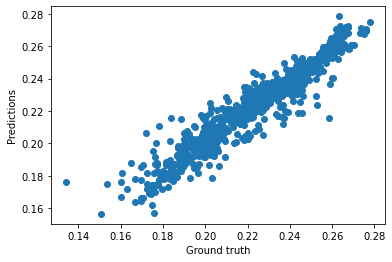

In [54]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [25]:
#%store model_fl_relative_support_x

In [26]:
#for idx, prediction in enumerate(predictions):
#    print(f'Start: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [27]:
# Save model
#joblib.dump(model_fl_relative_support_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_fl_relative_support_x.sav")

### Predict FL foot -> y

In [55]:
# Input
X = np.hstack((X_relative_footsteps_acc_FL_support[:, :3], # prev velocity command
               X_relative_footsteps_acc_FL_support[:, -3:], # commanded velocity command
               X_relative_footsteps_acc_FL_support[:, 9:11], # FL (x,y) position
               X_relative_footsteps_acc_FL_support[:, 12:14], # FR (x,y) position
               X_relative_footsteps_acc_FL_support[:, 15:17], # RL (x,y) position
               X_relative_footsteps_acc_FL_support[:, 18:20])) # RR (x,y) position

# Target
Y = np.array([Y_relative_footsteps_acc_FL_support[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True)

# Create the model
model_fl_relative_support_y = LinearRegression()

# Fit the model
model_fl_relative_support_y.fit(X_train, Y_train)

# Predict
predictions = model_fl_relative_support_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.945810231363893
RMSE:  0.008633765932216333
The lowest error is:  8.794822808494418e-06
The highest error is:  0.045148982139696314
The avg. error is:  0.005528388675475601


In [56]:
model_fl_relative_support_y.coef_

array([[ 0.00366699, -0.14955415, -0.09620165, -0.01551183, -0.04740276,
        -0.03234282,  0.11904886,  0.99749446,  0.19459777, -0.46219381,
         0.08415954, -0.00827589,  0.14635128,  0.25089739]])

In [57]:
model_fl_relative_support_y.intercept_

array([-0.04835997])

Text(0, 0.5, 'Predictions')

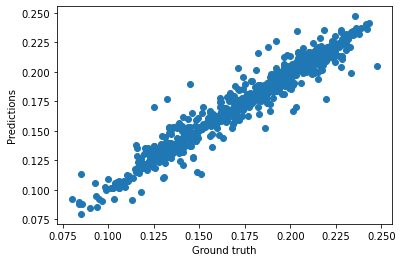

In [58]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [48]:
#%store model_fl_relative_support_y

In [49]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [50]:
# Save model
#joblib.dump(model_fl_relative_support_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_fl_relative_support_y.sav")